In [ ]:
import numpy as np
import pandas as pd
import os
from tflite_model_maker import configs
from tflite_model_maker import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import text_classifier
from tflite_model_maker.text_classifier import DataLoader
from tflite_model_maker.config import QuantizationConfig
from tensorflow.keras.preprocessing.text import Tokenizer

import tensorflow as tf
assert tf.__version__.startswith('2')
tf.get_logger().setLevel('ERROR')

In [2]:
# Remove and stopwords and special characters
from bs4 import BeautifulSoup
import string

stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

In [3]:
dataset = pd.read_csv('/tmp/spamDetection/spam.csv', encoding="ISO-8859-1")

In [4]:
dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
sentences = [] 
labels = []
for index, item in dataset.iterrows():
    sentence = item['v2'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append("positive") if item['v1'] == "spam" else labels.append("negative")

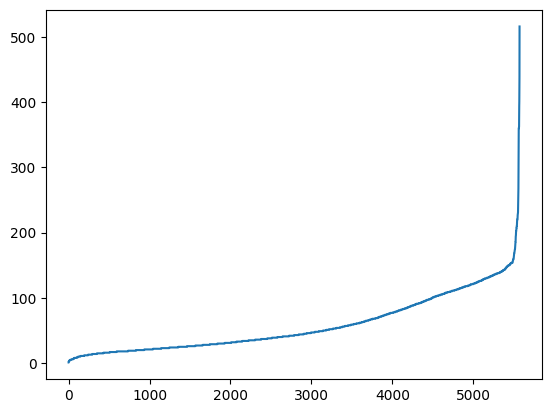

In [6]:
xs=[]
ys=[]
current_item=1
for item in sentences:
  xs.append(current_item)
  current_item=current_item+1
  ys.append(len(item))
newys = sorted(ys)

import matplotlib.pyplot as plt
plt.plot(xs,newys)
#plt.axis([26000, 27000, 50, 250])
plt.show()

#print(newys[26000])

In [7]:
vocab_size = 10000
oov_tok = ""

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)
wc=tokenizer.word_counts
print(wc)

OrderedDict([('go', 280), ('jurong', 1), ('point', 13), ('crazy', 15), ('available', 18), ('bugis', 7), ('n', 151), ('great', 115), ('world', 37), ('la', 7), ('e', 96), ('buffet', 2), ('cine', 7), ('got', 239), ('amore', 1), ('wat', 99), ('ok', 291), ('lar', 38), ('joking', 6), ('wif', 27), ('u', 1159), ('oni', 4), ('free', 282), ('entry', 26), ('2', 506), ('wkly', 14), ('comp', 12), ('win', 75), ('fa', 4), ('cup', 8), ('final', 18), ('tkts', 4), ('21st', 3), ('may', 50), ('2005', 3), ('text', 192), ('87121', 4), ('receive', 38), ('questionstd', 2), ('txt', 170), ('ratetcs', 2), ('apply', 32), ('08452810075over18s', 2), ('dun', 55), ('say', 92), ('early', 33), ('hor', 2), ('c', 86), ('already', 91), ('nah', 10), ('dont', 282), ('think', 132), ('goes', 26), ('usf', 11), ('lives', 4), ('around', 61), ('though', 27), ('freemsg', 12), ('hey', 112), ('darling', 5), ('3', 80), ('weeks', 19), ('now', 487), ('no', 353), ('word', 35), ('back', 153), ('like', 244), ('fun', 31), ('still', 156), (

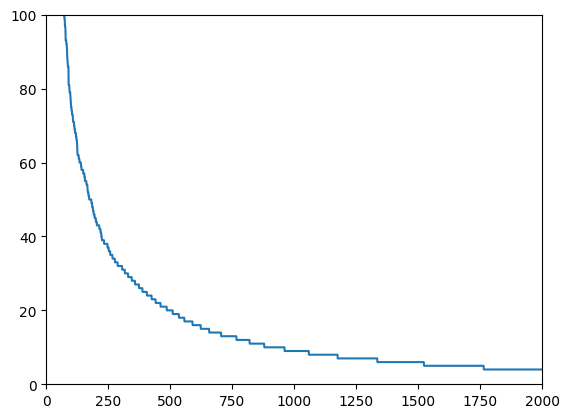

9
4


In [8]:
import matplotlib.pyplot as plt
wc = tokenizer.word_counts
from collections import OrderedDict
newlist = (OrderedDict(sorted(wc.items(), key=lambda t: t[1], reverse=True)))
xs=[]
ys=[]
curr_x = 1
for item in newlist:
  xs.append(curr_x)
  curr_x=curr_x+1
  ys.append(newlist[item])

plt.plot(xs,ys)
plt.axis([0,2000,0,100])
plt.show()
print(ys[1000])
print(ys[2000])

In [9]:
# Create new pandas dataframe and save as csv
dict = {'comments': sentences, 'label': labels}
df = pd.DataFrame(dict)
print(df)

                                               comments     label
0     go jurong point  crazy   available bugis n gre...  negative
1                        ok lar    joking wif u oni      negative
2     free entry 2 wkly comp win fa cup final tkts 2...  positive
3            u dun say early hor    u c already say      negative
4         nah dont think goes usf  lives around though   negative
...                                                 ...       ...
5567  2nd time tried 2 contact u  u won å£750 pound ...  positive
5568                  will ì b going esplanade fr home   negative
5569                       pity   mood     suggestions   negative
5570  guy bitching acted like interested buying some...  negative
5571                                   rofl  true name   negative

[5572 rows x 2 columns]


In [10]:
df.to_csv('/tmp/spamDetection/cleanuped_spam.csv', index=False)

In [11]:
# Load data from csv and split to test, train
#spec = model_spec.get('average_word_vec')
spec = model_spec.get('mobilebert_classifier')
spec.num_words = 500
spec.seq_len = 100
spec.wordvec_dim = 5
spec.dropout_rate = 0.2
spec.learning_rate = 0.00001

In [12]:
data = DataLoader.from_csv(
    filename="/tmp/spamDetection/cleanuped_spam.csv",
    text_column='comments',
    label_column='label',
    model_spec=spec,
    delimiter=',',
    shuffle=True,
    is_training=True)

train_data, test_data = data.split(0.9)

In [13]:
# Build the model
# model = text_classifier.create(train_data, model_spec=spec, epochs=50, validation_data=test_data)
model = text_classifier.create(train_data, model_spec=spec, epochs=10)

104/104 [==============================] - 71s 264ms/step - loss: 0.5209 - test_accuracy: 0.8782
Epoch 2/2
104/104 [==============================] - 29s 256ms/step - loss: 0.0996 - test_accuracy: 0.9704
Epoch 3/3
104/104 [==============================] - 29s 257ms/step - loss: 0.0632 - test_accuracy: 0.9854
Epoch 4/4
104/104 [==============================] - 28s 255ms/step - loss: 0.0553 - test_accuracy: 0.9874
Epoch 5/5
104/104 [==============================] - 29s 259ms/step - loss: 0.0463 - test_accuracy: 0.9908
Epoch 6/6
104/104 [==============================] - 29s 255ms/step - loss: 0.0357 - test_accuracy: 0.9936
Epoch 7/7
104/104 [==============================] - 28s 254ms/step - loss: 0.0210 - test_accuracy: 0.9954
Epoch 8/8
104/104 [==============================] - 29s 256ms/step - loss: 0.0175 - test_accuracy: 0.9966
Epoch 9/9
104/104 [==============================] - 29s 256ms/step - loss: 0.0136 - test_accuracy: 0.9976
Epoch 10/10
104/104 [==========================

In [14]:
loss, acc = model.evaluate(test_data)

18/18 [==============================] - 6s 59ms/step - loss: 0.1012 - test_accuracy: 0.9821


In [15]:
# Save model
export_dir = '/tmp/saved_model/spam/'
model.export(export_dir=export_dir, export_format=ExportFormat.SAVED_MODEL)

In [16]:
# This will export to TFLite format with the model only. 
# if you see a .json file in this directory, it is NOT the JSON model for TFJS
# See below for how to generate that.
# Please note that if you run this cell to create the tflite model then the 
# export to TFJS will fail. You'll need to rerun the model training first
model.export(export_dir=export_dir)

In [17]:
# If you want the labels and the vocab, for example for iOS, you can use this
model.export(export_dir=export_dir, export_format=[ExportFormat.LABEL, ExportFormat.VOCAB])

# You can find your files in colab by clicking the 'folder' tab to the left of
# this code window, and then navigating 'up' a directory to find the root
# directory listing -- and from there you should see /mm_spam/

In [18]:
# Use this section for export to TFJS
# Please note that if you run the above cell to create the tflite model then the 
# export to TFJS will fail. You'll need to rerun the model training first
#model.export(export_dir="/tmp/saved_model/spam/tfjs/", export_format=[ExportFormat.TFJS, ExportFormat.LABEL, ExportFormat.VOCAB])